# Transformer Encoder Only Model in PyTorch

- Below is a draft from my ongoing implementation towards the SAINT and SAINT+ papers introduced by the organizers. It's a WIP and is based on my understanding. So for sure, there might be bugs in it and that's why you, being the reader should consider letting me know the same and be a responsible citizen of Kaggle's kingdom :)

- Not added validation mechanism as i am little bit confused as of now, once that's cleared, i will update it for sure.

- Host's papers (https://arxiv.org/abs/2002.07033, https://arxiv.org/abs/2010.12042).

In [1]:
# import some typical packages and fix few random seed.
# Plz fix the torch seed as well...
# NB many imports are not used, but they are just there...

import numpy as np
import pandas as pd
import pickle
import gc
import time
import itertools

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, auc, roc_curve
from contextlib import contextmanager
from pathlib import Path
from time import time
from collections import namedtuple

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
gc.enable()

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from torch.nn.modules.dropout import Dropout
from torch.nn.modules.activation import MultiheadAttention
from torch.nn.modules.normalization import LayerNorm

TRAIN_DTYPES = {
    # 'row_id': np.uint32,
    'timestamp': np.uint64,
    'user_id': np.uint32,
    'content_id': np.uint16,
    'content_type_id': np.uint8,
    'task_container_id': np.uint16,
    'user_answer': np.int8,
    'answered_correctly': np.int8,
    'prior_question_elapsed_time': np.float32,
    'prior_question_had_explanation': 'boolean'
}

DATA_DIR = Path('/Users/hesu/Documents/KT/riiid')
TRAIN_PATH = DATA_DIR / 'train.csv'
QUESTIONS_PATH = DATA_DIR / 'questions.csv'
LECTURES_PATH = DATA_DIR / 'lectures.csv'

In [2]:
%%time

LAST_N = 100 # this parameter denotes how many last seen content_ids I am going to consider <aka the max_seq_len or the window size>.

df_questions = pd.read_csv(QUESTIONS_PATH)
df_train = pd.read_csv(TRAIN_PATH, nrows=40_00_000, dtype=TRAIN_DTYPES, usecols=TRAIN_DTYPES.keys())

df_train['prior_question_had_explanation'] = df_train['prior_question_had_explanation'].astype(np.float16).fillna(-1).astype(np.int8)
df_train = df_train[df_train.content_type_id == 0]

part_ids_map = dict(zip(df_questions.question_id, df_questions.part))
df_train['part_id'] = df_train['content_id'].map(part_ids_map)

CPU times: user 3.66 s, sys: 336 ms, total: 4 s
Wall time: 4.11 s


In [3]:
part_ids_map

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 122: 1,
 12

In [5]:
df_questions.question_id

0            0
1            1
2            2
3            3
4            4
         ...  
13518    13518
13519    13519
13520    13520
13521    13521
13522    13522
Name: question_id, Length: 13523, dtype: int64

In [6]:
from collections import Counter
df_train["prior_question_elapsed_time"].fillna(26000, inplace=True) # some random value fill in
df_train["prior_question_elapsed_time"] = df_train["prior_question_elapsed_time"] // 1000

# Preparing the Dataset

In [4]:
%%time

from collections import deque

# we will be using a deque as it automatically limits the max_size as per the Data Strucutre's defination itself
# so we don't need to manage that...

d = {}
user_id_to_idx = {}

PAD = 0

grp = df_train.groupby("user_id").tail(LAST_N) # Select last_n rows of each user.

for idx, row in tqdm(grp.groupby("user_id").agg({
    "content_id":list, "answered_correctly":list, "task_container_id":list, 
    "part_id":list, "prior_question_elapsed_time":list
}).reset_index().iterrows()):
    # here we make a split whether a user has more than equal to 100 entries or less than that
    # if it's less than LAST_N, then we need to PAD it using the PAD token defined as 0 by me in this cell block
    # also, padded will be True where we have done padding obviously, rest places it's False.
    if len(row["content_id"]) >= 100:
        d[idx] = {
            "user_id": row["user_id"],
            "content_id" : deque(row["content_id"], maxlen=LAST_N),
            "answered_correctly" : deque(row["answered_correctly"], maxlen=LAST_N),
            "task_container_id" : deque(row["task_container_id"], maxlen=LAST_N),
            "prior_question_elapsed_time" : deque(row["prior_question_elapsed_time"], maxlen=LAST_N),
            "part_id": deque(row["part_id"], maxlen=LAST_N),
            "padded" : deque([False]*100, maxlen=LAST_N)
        }
    else:
        # we have to pad...
        # (max_batch_len - len(seq))
        d[idx] = {
            "user_id": row["user_id"],
            "content_id" : deque(row["content_id"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "answered_correctly" : deque(row["answered_correctly"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "task_container_id" : deque(row["task_container_id"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "prior_question_elapsed_time" : deque(row["prior_question_elapsed_time"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "part_id": deque(row["part_id"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "padded" : deque([False]*len(row["content_id"]) + [True]*(100-len(row["content_id"])), maxlen=LAST_N)
        }
    user_id_to_idx[row["user_id"]] = idx
    # if in future a new user comes, we will just increase the counts as of now... <WIP>


CPU times: user 5.6 s, sys: 173 ms, total: 5.77 s
Wall time: 5.76 s


In [5]:
print(d[0]) # user_id 115; I encourage you to match the same with the dataframes.

{'user_id': 115, 'content_id': deque([5692, 5716, 128, 7860, 7922, 156, 51, 50, 7896, 7863, 152, 104, 108, 7900, 7901, 7971, 25, 183, 7926, 7927, 4, 7984, 45, 185, 55, 7876, 6, 172, 7898, 175, 100, 7859, 57, 7948, 151, 167, 7897, 7882, 7962, 1278, 2065, 2064, 2063, 3363, 3365, 3364, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], maxlen=100), 'answered_correctly': deque([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], maxlen=100), 'task_container_id': deque([1, 2, 0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 40, 40, 41, 41,

In [6]:
# this user has been known to me as 0th user basically. If a user comes which is unseen in past, 
# simply hash it to the len of the dict and increment that value; keping this just for reference and debugging.
user_id_to_idx[115]

0

# A Minimal Transformer Model

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ninp:int=32, nhead:int=2, nhid:int=64, nlayers:int=2, dropout:float=0.3):
        '''
        nhead -> number of heads in the transformer multi attention thing.
        nhid -> the number of hidden dimension neurons in the model.
        nlayers -> how many layers we want to stack.
        '''
        super(TransformerModel, self).__init__()
        self.src_mask = None
        encoder_layers = TransformerEncoderLayer(d_model=ninp, nhead=nhead, dim_feedforward=nhid, dropout=dropout, activation='relu')
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers, num_layers=nlayers)
        self.exercise_embeddings = nn.Embedding(num_embeddings=13523, embedding_dim=ninp) # exercise_id
        self.pos_embedding = nn.Embedding(ninp, ninp) # positional embeddings
        self.part_embeddings = nn.Embedding(num_embeddings=7+1, embedding_dim=ninp) # part_id_embeddings
        self.prior_question_elapsed_time = nn.Embedding(num_embeddings=301, embedding_dim=ninp) # prior_question_elapsed_time
        self.device = "cpu"
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, 2)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        # init embeddings
        self.exercise_embeddings.weight.data.uniform_(-initrange, initrange)
        self.part_embeddings.weight.data.uniform_(-initrange, initrange)
        self.prior_question_elapsed_time.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, content_id, part_id, prior_question_elapsed_time=None, mask_src=None):
        '''
        S is the sequence length, N the batch size and E the Embedding Dimension (number of features).
        src: (S, N, E)
        src_mask: (S, S)
        src_key_padding_mask: (N, S)
        padding mask is (N, S) with boolean True/False.
        SRC_MASK is (S, S) with float(’-inf’) and float(0.0).
        '''

        embedded_src = self.exercise_embeddings(content_id) + \
        self.pos_embedding(torch.arange(0, content_id.shape[1]).to(self.device).unsqueeze(0).repeat(content_id.shape[0], 1)) + \
        self.part_embeddings(part_id) + self.prior_question_elapsed_time(prior_question_elapsed_time) # (N, S, E)
        embedded_src = embedded_src.transpose(0, 1) # (S, N, E)
        
        _src = embedded_src * np.sqrt(self.ninp)
        
        output = self.transformer_encoder(src=_src, src_key_padding_mask=mask_src)
        output = self.decoder(output)
        output = output.transpose(1, 0)
        return output

In [8]:
from typing import List

def pad_seq(seq: List[int], max_batch_len: int = LAST_N, pad_value: int = True) -> List[int]:
    return seq + (max_batch_len - len(seq)) * [pad_value]

In [9]:
# pytorch dataset class

class Riiid(torch.utils.data.Dataset):
    
    def __init__(self, d):
        self.d = d
    
    def __len__(self):
        return len(self.d)
    
    def __getitem__(self, idx):
        # you can return a dict of these as well etc etc...
        # remember the order
        return idx, self.d[idx]["content_id"], self.d[idx]["task_container_id"], \
    self.d[idx]["part_id"], self.d[idx]["prior_question_elapsed_time"], self.d[idx]["padded"], \
    self.d[idx]["answered_correctly"]

def collate_fn(batch):
    _, content_id, task_id, part_id, prior_question_elapsed_time, padded, labels = zip(*batch)
    content_id = torch.Tensor(content_id).long()
    task_id = torch.Tensor(task_id).long()
    part_id = torch.Tensor(part_id).long()
    prior_question_elapsed_time = torch.Tensor(prior_question_elapsed_time).long()
    padded = torch.Tensor(padded).bool()
    labels = torch.Tensor(labels)
    # remember the order
    return content_id, task_id, part_id, prior_question_elapsed_time, padded, labels

In [10]:
dataset = Riiid(d=d)

In [11]:
print(dataset[0]) # sample dataset

(0, deque([5692, 5716, 128, 7860, 7922, 156, 51, 50, 7896, 7863, 152, 104, 108, 7900, 7901, 7971, 25, 183, 7926, 7927, 4, 7984, 45, 185, 55, 7876, 6, 172, 7898, 175, 100, 7859, 57, 7948, 151, 167, 7897, 7882, 7962, 1278, 2065, 2064, 2063, 3363, 3365, 3364, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], maxlen=100), deque([1, 2, 0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 40, 40, 41, 41, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], maxlen=100), deque([5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
next(iter(torch.utils.data.DataLoader(dataset=dataset, batch_size=1, collate_fn=collate_fn, num_workers=8))) # dummy check

(tensor([[5692, 5716,  128, 7860, 7922,  156,   51,   50, 7896, 7863,  152,  104,
           108, 7900, 7901, 7971,   25,  183, 7926, 7927,    4, 7984,   45,  185,
            55, 7876,    6,  172, 7898,  175,  100, 7859,   57, 7948,  151,  167,
          7897, 7882, 7962, 1278, 2065, 2064, 2063, 3363, 3365, 3364,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0]]),
 tensor([[ 1,  2,  0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
          36, 37, 38, 39, 40, 40, 40, 41, 41, 41,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [13]:
# createing the mdoel
model = TransformerModel(ninp=LAST_N, nhead=4, nhid=128, nlayers=3, dropout=0.3)
model # look into it!

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=128, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=128, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
     

In [14]:
# dummy stuff

BATCH_SIZE = 32
losses = []
criterion = nn.BCEWithLogitsLoss()
lr = 1e-3 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train();

In [15]:
# here we train, NB I have doubta as to what i am doing, so please take it lightly.
for idx,batch in tqdm(enumerate(torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=8))):
    content_id, _, part_id, prior_question_elapsed_time, mask, labels = batch
    optimizer.zero_grad()
    with torch.set_grad_enabled(mode=True):
        output = model(content_id, part_id, prior_question_elapsed_time, mask)
        # output is (N,S,2) # i am working on it
        loss = criterion(output[:,:,1], labels)
        loss.backward()
        losses.append(loss.detach().data.numpy())
        optimizer.step()

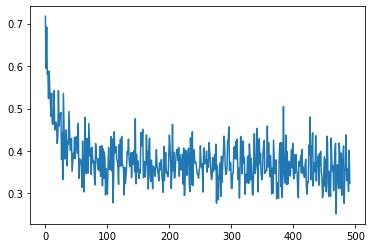

In [16]:
pd.Series(losses).astype(np.float32).plot(kind="line")

# **** NB I AM NOT SURE ABOUT THIS VALIDATION THING AS OF NOW ****

In [17]:
df_valid = pd.read_csv(TRAIN_PATH, nrows=20_00_000, dtype=TRAIN_DTYPES, 
                       usecols=TRAIN_DTYPES.keys(), skiprows=range(1, 40_00_000)
                      )
df_valid = df_valid[df_valid.content_type_id == 0]

df_valid["prior_question_elapsed_time"].fillna(26000, inplace=True)
df_valid["prior_question_elapsed_time"] = df_valid["prior_question_elapsed_time"] // 1000

part_ids_map = dict(zip(df_questions.question_id, df_questions.part))
df_valid['part_id'] = df_valid['content_id'].map(part_ids_map)

In [18]:
from collections import deque
d = {}
user_id_to_idx = {}
PAD = 0

grp = df_valid.groupby("user_id").tail(LAST_N)
for idx, row in tqdm(grp.groupby("user_id").agg({
    "content_id":list, "answered_correctly":list, "task_container_id":list, 
    "part_id":list, "prior_question_elapsed_time":list
}).reset_index().iterrows()):
    if len(row["content_id"]) >= 100:
        d[idx] = {
            "user_id": row["user_id"],
            "content_id" : deque(row["content_id"], maxlen=LAST_N),
            "answered_correctly" : deque(row["answered_correctly"], maxlen=LAST_N),
            "task_container_id" : deque(row["task_container_id"], maxlen=LAST_N),
            "prior_question_elapsed_time" : deque(row["prior_question_elapsed_time"], maxlen=LAST_N),
            "part_id": deque(row["part_id"], maxlen=LAST_N),
            "padded" : deque([False]*100, maxlen=LAST_N)
        }
    else:
        # we have to pad...
        # (max_batch_len - len(seq))
        d[idx] = {
            "user_id": row["user_id"],
            "content_id" : deque(row["content_id"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "answered_correctly" : deque(row["answered_correctly"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "task_container_id" : deque(row["task_container_id"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "prior_question_elapsed_time" : deque(row["prior_question_elapsed_time"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "part_id": deque(row["part_id"] + [PAD]*(100-len(row["content_id"])), maxlen=LAST_N),
            "padded" : deque([False]*len(row["content_id"]) + [True]*(100-len(row["content_id"])), maxlen=LAST_N)
        }
    user_id_to_idx[row["user_id"]] = idx

In [19]:
def roc_auc_compute_fn(y_targets, y_preds):
    try:
        from sklearn.metrics import roc_auc_score
    except ImportError:
        raise RuntimeError("This contrib module requires sklearn to be installed.")

    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
    return roc_auc_score(y_true, y_pred)

In [20]:
# **** NB I AM NOT SURE ABOUT THIS VALIDATION THING AS OF NOW ****

from sklearn.metrics import accuracy_score

model.eval();
dataset = Riiid(d=d)
scores = []

for idx,batch in tqdm(enumerate(torch.utils.data.DataLoader(dataset=dataset, batch_size=32, collate_fn=collate_fn, drop_last=True))):
    content_id, _, part_id, prior_question_elapsed_time, mask, labels = batch
    with torch.set_grad_enabled(mode=False):
            output = model(content_id, part_id, prior_question_elapsed_time, mask)
            output_prob = output[:,:,1]
            pred = output_prob >= 0.50
            # print(output.shape, labels.shape) # torch.Size([N, S, 2]) torch.Size([N, S])
            _, predicted = torch.max(output[:,:,].data, 1)
            try:
                score = roc_auc_compute_fn(labels, pred)
                scores.append(score)
            except:
                print("Metric calculation failed for", idx)
                continue
np.mean(scores)

0.7407194438081431

That's it for now, stay tuned for updates! Plz let me know my bugs!